In [1]:
import pandas as pd
import statsmodels.api as sm
%matplotlib inline

In [2]:
def visualize_tree(tree, feature_names):
    """Create tree png using graphviz.

    Args
    ----
    tree -- scikit-learn DecsisionTree.
    feature_names -- list of feature names.
    """
    with open("dt.dot", 'w') as f:
        export_graphviz(tree, out_file=f)

    command = ["dot", "-Tpng", "dt.dot", "-o", "dt.png"]
    try:
        subprocess.check_call(command)
    except:
        exit("Could not run dot, ie graphviz, to "
             "produce visualization")

1) Load in the dataset `https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv` into a pandas dataframe

In [3]:
df =pd.read_csv('https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv',index_col=0)

In [4]:
df.head()

,default,student,balance,income
1,No,No,729.526495,44361.625074
2,No,Yes,817.180407,12106.134700
3,No,No,1073.549164,31767.138947
4,No,No,529.250605,35704.493935
5,No,No,785.655883,38463.495879


2) Convert `default` and `student` to categorical variables.

In [5]:
df_default=pd.get_dummies(df['default'])
df_student=pd.get_dummies(df['student'])
df_default.columns=['defaultNo','defaultYes']
df_student.columns=['studentNo','studentYes']
df_final = pd.concat([df[['balance','income']],df_default,df_student],axis=1)

In [6]:
df_final.head()

,balance,income,defaultNo,defaultYes,studentNo,studentYes
1,729.526495,44361.625074,1,0,1,0
2,817.180407,12106.134700,1,0,0,1
3,1073.549164,31767.138947,1,0,1,0
4,529.250605,35704.493935,1,0,1,0
5,785.655883,38463.495879,1,0,1,0


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color
of the outcome of `default` labeled red if yes and blue if no. 

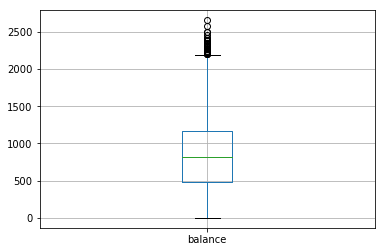

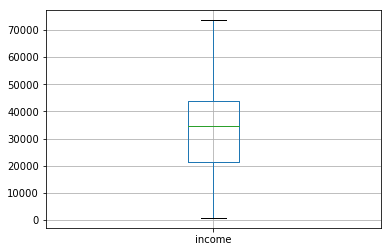

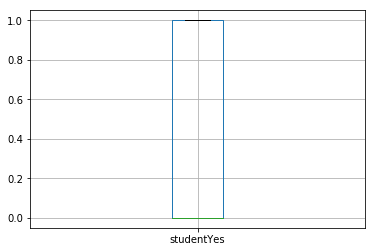

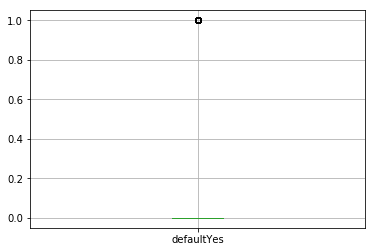

In [7]:
import pylab as plt
df_final[['balance']].boxplot()
plt.show()
df_final[['income']].boxplot()
plt.show()
df_final[['studentYes']].boxplot()
plt.show()
df_final[['defaultYes']].boxplot()
plt.show()

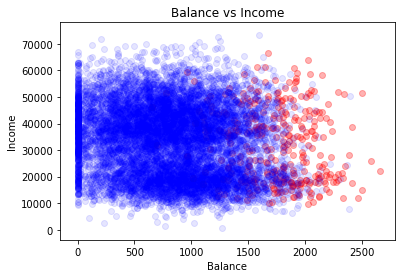

In [8]:
plt.title('Balance vs Income')
df_default = df_final[df_final['defaultYes']==1]
df_non_default = df_final[df_final['defaultNo']==1]
plt.scatter(df_default['balance'],df_default['income'],color='red', alpha=.3)
plt.scatter(df_non_default['balance'],df_non_default['income'],color='blue', alpha=.1)
plt.xlabel('Balance')
plt.ylabel('Income')
plt.figure()

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley
on the `balance` and `income` variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

In [9]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
import numpy as np

y = df_final['defaultYes'].copy()
X = df_final[['balance','income']].copy()
X = np.array(X.values)
y = np.array(y.values)

Coefficients of Decision Boundary are 0.005436 and 0.000018


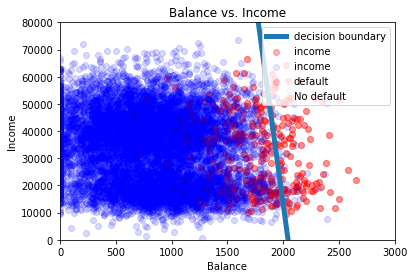

In [10]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l1')
clf.fit(X, y)

w = clf.coef_[0]
print (('Coefficients of Decision Boundary are %f and %f') % (clf.coef_[0][0],clf.coef_[0][1]))

a = -w[0] / w[1]
xx = np.linspace(0,2500)
yy = a * xx - (clf.intercept_) / w[1]
plt.plot(xx, yy, alpha = 1, zorder = 2, linewidth = 5, label = 'decision boundary')
plt.scatter(df_default['balance'],df_default['income'],color='red', alpha=.3)
plt.scatter(df_non_default['balance'],df_non_default['income'],color='blue', alpha=.1)
plt.xlabel('Balance')
plt.ylabel('Income')
plt.xlim(0,3000)
plt.ylim(0,80000)
plt.scatter(df_default['balance'],df_default['income'],color='red', alpha=.2, zorder = 1, label = "default")
plt.scatter(df_non_default['balance'],df_non_default['income'],color='blue', alpha=.05, zorder = 1, label = "No default")
plt.title('Balance vs. Income')
plt.legend(loc = 'upper right')
plt.figure()

In [11]:
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Computes the AUC ROC of the classifier.
def generate_auc(X,y,clf_class,**kwargs):
    random_state = np.random.RandomState(0)
    # Construct training and testing set.
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    X, y = shuffle(X, y, random_state=random_state)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Choose SVC classifier.
    classifier = clf_class(**kwargs)
    clf = classifier.fit(X_train, y_train)
#     print (clf.coef_,clf.intercept_)
    probas_ = clf.predict_proba(X_test)
    
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    print ("Area under the ROC curve : %f" % roc_auc)
    return fpr, tpr, roc_auc, clf

def generate_ROCplot(fpr,tpr,title,roc_auc):
    plt.clf()
    plt.plot(fpr, tpr, '.-',label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC with %s' %title)
    plt.legend(loc="lower right")
    plt.show()

Area under the ROC curve : 0.958831


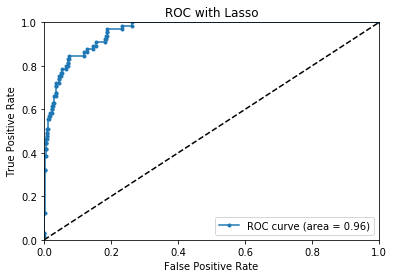

In [12]:
fpr, tpr, roc_auc, clf= generate_auc(X,y,LogisticRegression,penalty='l1')
generate_ROCplot(fpr, tpr, 'Lasso', roc_auc)

5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking
of coefficients.  How does performance improve with the added variable?

In [13]:
X2 = df_final[['balance','income','studentYes']].copy()
X2 = np.array(X2.values)
scaler = StandardScaler()
X2 = scaler.fit_transform(X2)

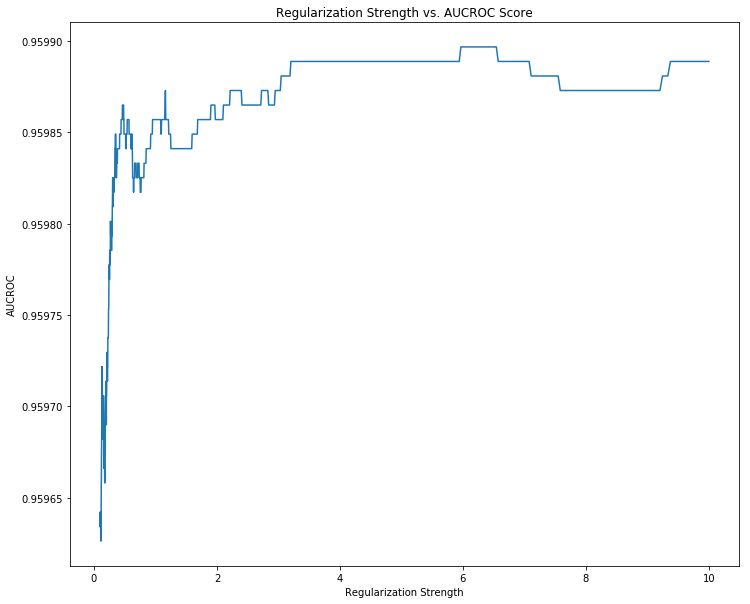

In [14]:
scores = []
random_state = np.random.RandomState(0)
X2, y = shuffle(X2, y, random_state=random_state)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
alphas = np.logspace(-1,1,1000)
for alpha in alphas:
    regr = LogisticRegression(penalty='l2',C=alpha)
    probas_ = regr.fit(X2_train, y_train).predict_proba(X2_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    scores.append(roc_auc)
plt.figure(figsize=(12,10))
plt.title('Regularization Strength vs. AUCROC Score')
plt.xlabel('Regularization Strength')
plt.ylabel('AUCROC')
plt.plot(alphas,scores)

In [15]:
best_alpha_index = np.argmax(scores)
best_alpha = alphas[best_alpha_index]
print("Regularization strength to optimize AUCROC:",alphas[best_alpha_index])
print("Optimized AUCROC:", scores[best_alpha_index])

Regularization strength to optimize AUCROC: 5.96727119597
Optimized AUCROC: 0.959896640827


C:\Users\Jason\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


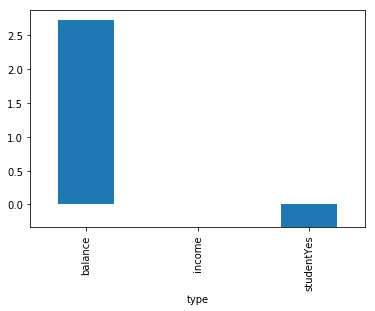

In [16]:
regr = LogisticRegression(C=alpha,penalty='l1')
regr.fit(X2_train, y_train)
dfCoeffs = pd.DataFrame({'type':df_final[['balance','income','studentYes']].columns.values, 'coef':regr.coef_[0]})
dfCoeffs2 = dfCoeffs.groupby('type')['coef'].mean()
dfCoeffs2.sort()
dfCoeffs2[::-1].plot(kind='bar')

As we can see from the plots of the coefficients, the most important feature is "balance". The "student" feature does not have that large of a coefficient. Thus, adding it in doesn't make that big of a difference in the performance. 

6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

C:\Users\Jason\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


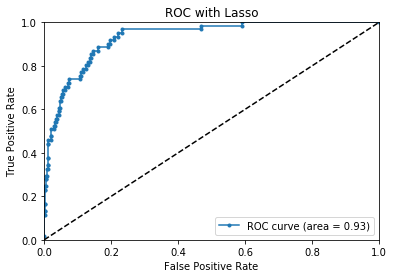

[ 2.82065044  0.11415886 -0.21216238]


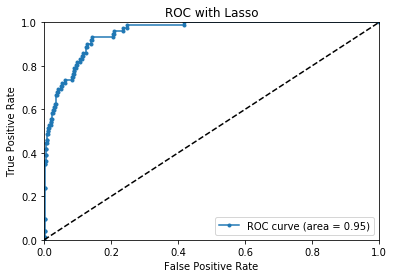

[ 2.75136473  0.14817209 -0.20836968]


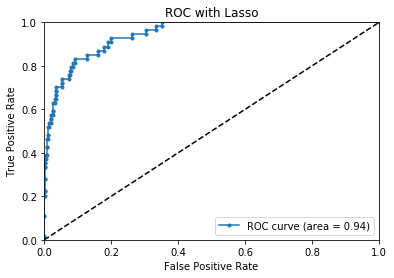

[ 2.736622   -0.05104518 -0.39066391]


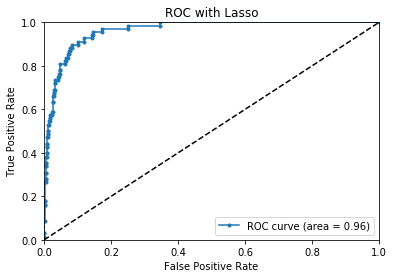

[ 2.67351455 -0.02422822 -0.32914109]


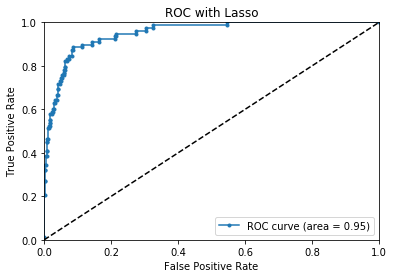

[ 2.73827189  0.02907367 -0.29753345]


In [17]:
from sklearn.cross_validation import KFold

def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
#     y_pred = y.copy()
    y_pred = np.zeros(len(y))
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
#         X_train, X_test = X[train_index], X[test_index]
#         y_train = y[train_index]
        X_train = []
        y_train = []
        for i in train_index:
            X_train.append(X[i])
            y_train.append(y[i])
        X_test = []
        y_test = []
        for i in test_index:
            X_test.append(X[i])
            y_test.append(y[i])


        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        probas_ = clf.predict_proba(X_test)
    
        fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
        roc_auc = auc(fpr, tpr)
        generate_ROCplot(fpr, tpr, 'Lasso', roc_auc)   
        print (clf.coef_[0])
        coeffs.append(clf.coef_)
        y_ = clf.predict(X_test)
        for i in range(len(test_index)):
            y_pred[test_index[i]] = y_[i]
    return coeffs

coeffs=run_cv_coeffs(X2,y,LogisticRegression,C=best_alpha,penalty='l2')


From these different runs, we can see that, when cross-validated, the results are still uniformly consistent with a high AUCROC near 1. Thus, our model is robust. 

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

In [18]:
print(__doc__)

# Import the necessary modules and libraries
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy.random as nprnd
import random
import seaborn
%matplotlib inline

Automatically created module for IPython interactive environment


In [19]:
regr_5 = DecisionTreeRegressor(max_depth=5)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
regr_5.fit(X2_train,y_train)
y_pred = regr_5.predict(X2_test)

from __future__ import print_function

import os
import subprocess

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
dt=DecisionTreeRegressor(max_depth=5)
visualize_tree(regr_5, feature_names=['x'])

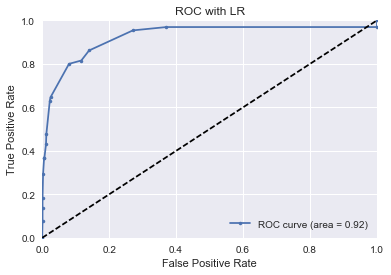

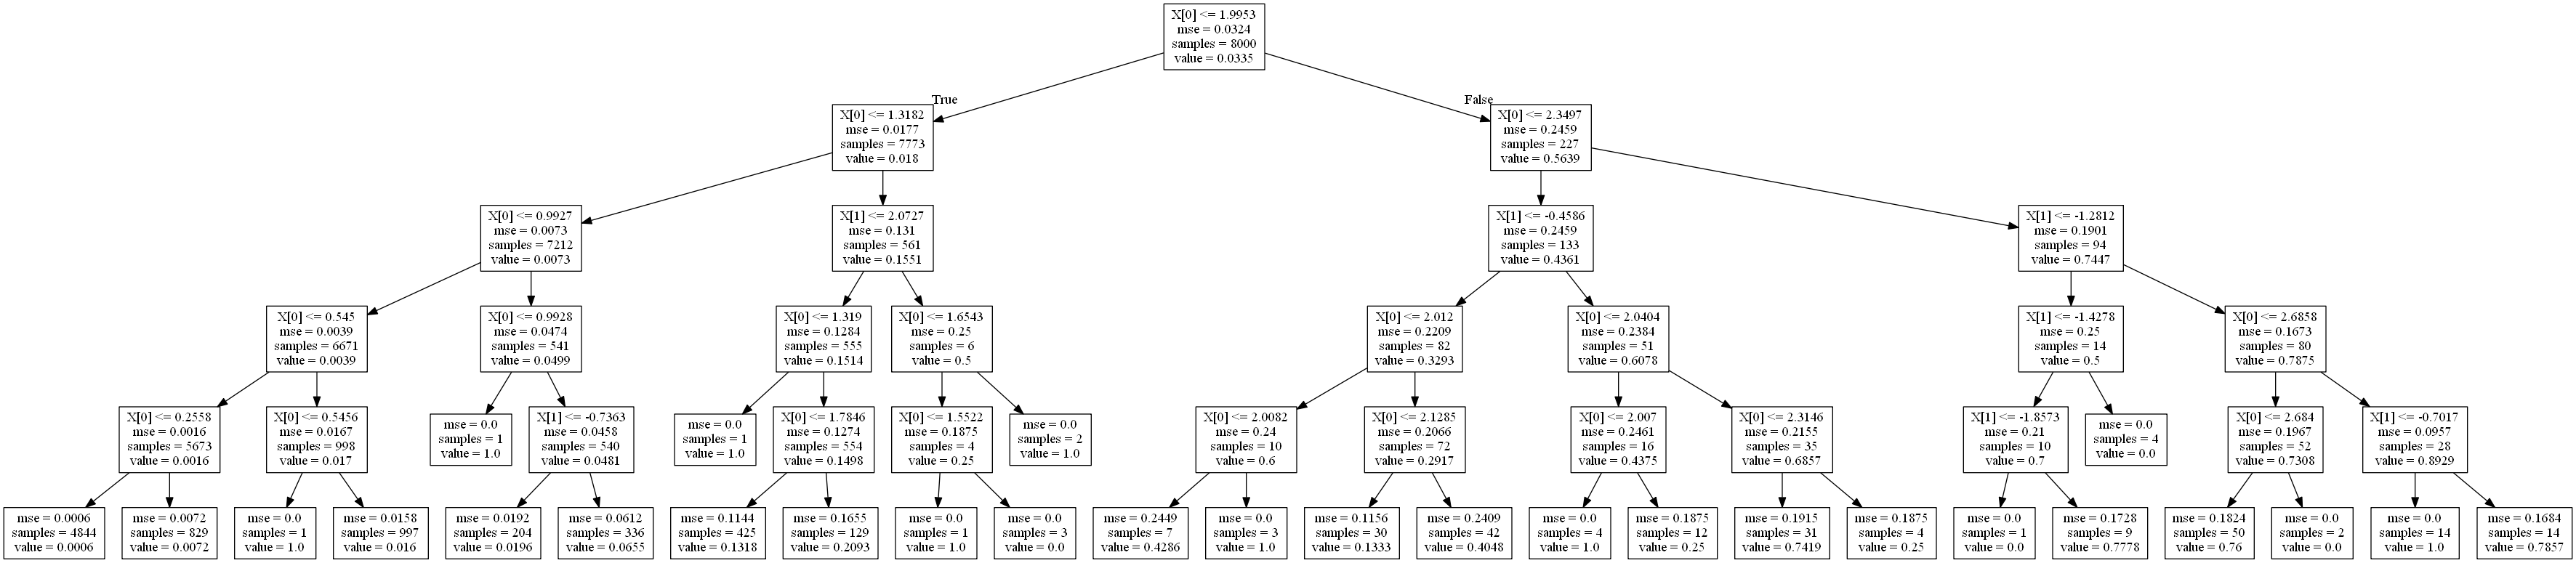

In [20]:
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from __future__ import print_function
import pydotplus
import os
from IPython.display import Image  
dot_data=export_graphviz(regr_5, out_file=None)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
generate_ROCplot(fpr,tpr,'LR',roc_auc)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png()) 

The AUC ROC here is .92, meaning that performance is slightly worse than when we used the Logistic Regression. 

8) Find the optimal decision tree depth and compute the AUC ROC. 

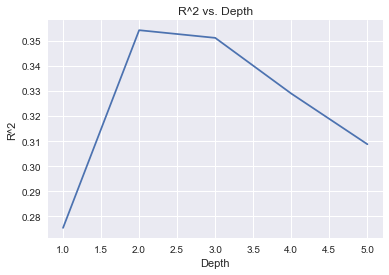

In [21]:
from sklearn.model_selection import train_test_split
X2_train, X2_test, y_train, y_test = train_test_split(
    X2, y, test_size=0.2, random_state=42)
train_errors=[]
test_errors=[]
scores=[]
depths = range(1,6)
for n in depths:
    regr = DecisionTreeRegressor(max_depth=n)
    # Train the model using the training sets
    regr.fit(X2_train, y_train)
    train_errors.append(regr.score(X2_train,y_train))
    scores.append(regr.score(X2_test,y_test))
plt.ylabel('R^2')
plt.xlabel('Depth')
plt.title('R^2 vs. Depth')
plt.plot(depths,scores)
test_errors=scores
n_opt=depths[np.argmax(scores)]

In [22]:
print("The optimal decision tree depth is: ", n_opt)

The optimal decision tree depth is:  2


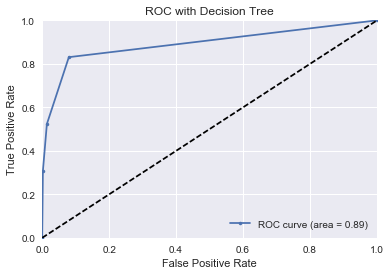

In [23]:
regr_opt = DecisionTreeRegressor(max_depth=n_opt)
regr_opt.fit(X2_train, y_train)

y_pred = regr_opt.predict(X2_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
generate_ROCplot(fpr,tpr,'Decision Tree',roc_auc)

The AUC ROC for a decision tree with optimal depth of 2 is .89. 